# all imports

In [1]:
import torch
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rnn_type = nn.GRU # or nn.GRU

In [3]:
data = pd.read_csv("order-data.csv")
data = data.iloc[:,1:158]
data.head()

,1,2,3,4,5,6,7,8,9,10,...,147,148,149,150,151,152,153,154,155,156
0,0.0,0.0,0.0,86.0,0.0,0.0,0.0,29.0,0.0,0.0,...,186.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0,0.0,892.0
1,0.0,0.0,0.0,79.0,0.0,0.0,0.0,19.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,1001.0,0.0,0.0,0.0,1000.0,0.0,0.0,...,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0
3,0.0,0.0,0.0,577.0,0.0,0.0,0.0,400.0,0.0,0.0,...,434.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,0.0,1028.0
4,0.0,0.0,0.0,5.0,0.0,0.0,0.0,70.0,0.0,0.0,...,892.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0,0.0,4000.0


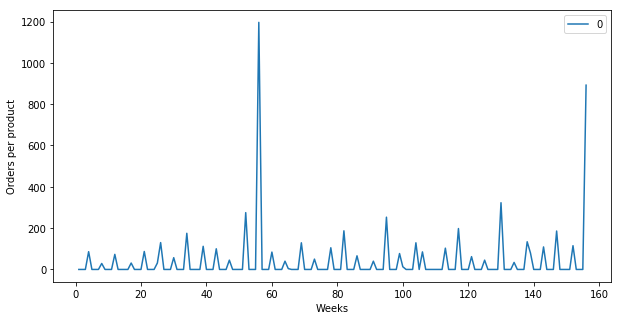

In [4]:
plot_data = data.head(1)
x = range(1,157)

plt.figure(figsize=(10,5))

for i,row in plot_data.iterrows():
    plt.plot(x,row)

plt.legend(plot_data.index)
plt.xlabel("Weeks")
plt.ylabel("Orders per product")
plt.show()

In [5]:
# selecting the training data. Use 51 weeks and leave 1 week out.

data_train = data.iloc[:,:-1]
inputs = torch.Tensor(data_train.values).unsqueeze(1)

# shift index axis by a given period in positive/negative direction
# axis = 0 is set by default
# in our case here, we move everything to the left and the right most
# column adds nan. you can play with the negative -1 value and print targets
# to see the effect

targets = data_train.shift(-4, axis="columns").astype(dtype = "float32")
#print(data)
#print(targets)
targets['152'] = data['153']
targets['153'] = data['154']
targets['154'] = data['155']
targets['155'] = data['156']
targets = torch.Tensor(targets.values)
print(targets.shape)

torch.Size([23594, 155])


# Defining our model

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super(RNN, self).__init__()
        
        # hidden dimension size
        self.hidden_size = hidden_size
        
        # Add an LSTM/GRU layer:
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        
        # Add a fully-connected layer:
        self.output = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.view(-1, self.hidden_size)
        out = self.output(out)
        
        return out, hidden

# Instantiate the model, define loss and optimization functions

In [7]:
model = RNN(data_train.shape[1], 10, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5000

model

RNN(
  (rnn): GRU(155, 10, batch_first=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
import time

start_time = time.time()
losses = []

for i in range(1, epochs+1):
    
    hidden = None
    pred, hidden = model(inputs, hidden)
    
    loss = criterion(pred, targets)
    # reset the parameters and hidden states
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if i%100 == 0:
        # print training result
        print(f'Epoch: {i} Loss: {loss.item():10.8f}')
        

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

/Users/saidulislam/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([23594, 155])) that is different to the input size (torch.Size([23594, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 100 Loss: 354266.90625000
Epoch: 200 Loss: 354201.71875000
Epoch: 300 Loss: 354142.37500000
Epoch: 400 Loss: 354091.12500000
Epoch: 500 Loss: 354044.43750000
Epoch: 600 Loss: 354002.71875000
Epoch: 700 Loss: 353962.62500000
Epoch: 800 Loss: 353924.81250000
Epoch: 900 Loss: 353888.25000000
Epoch: 1000 Loss: 353852.68750000
Epoch: 1100 Loss: 353817.87500000
Epoch: 1200 Loss: 353784.12500000
Epoch: 1300 Loss: 353750.03125000
Epoch: 1400 Loss: 353716.46875000
Epoch: 1500 Loss: 353683.56250000
Epoch: 1600 Loss: 353647.43750000
Epoch: 1700 Loss: 353612.65625000
Epoch: 1800 Loss: 353571.93750000
Epoch: 1900 Loss: 353536.15625000
Epoch: 2000 Loss: 353508.34375000
Epoch: 2100 Loss: 353470.87500000
Epoch: 2200 Loss: 353427.68750000
Epoch: 2300 Loss: 353386.56250000
Epoch: 2400 Loss: 353345.56250000
Epoch: 2500 Loss: 353306.03125000
Epoch: 2600 Loss: 353267.68750000
Epoch: 2700 Loss: 353234.31250000
Epoch: 2800 Loss: 353198.59375000
Epoch: 2900 Loss: 353159.34375000
Epoch: 3000 Loss: 35311

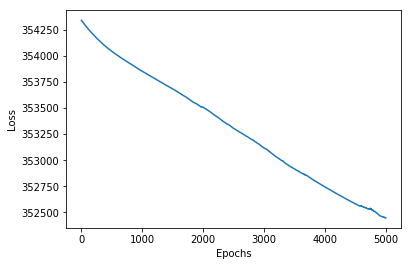

In [13]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

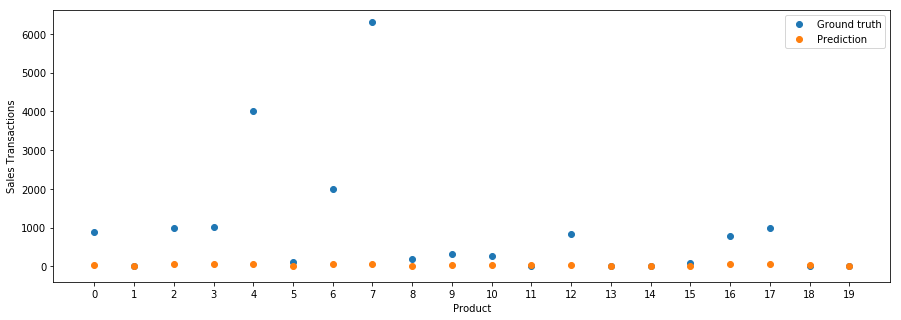

In [9]:
x_range = range(len(data))
target = data.iloc[:,-1].values.reshape(len(data),1)
plt.figure(figsize=(15,5))
plt.scatter(x_range[:20], target[:20])
plt.scatter(x_range[:20], pred.detach().numpy()[:20])
plt.legend(["Ground truth", "Prediction"])
plt.xlabel("Product")
plt.ylabel("Sales Transactions")
plt.xticks(range(0, 20))
plt.show()

# 156 weeks sales of item 1 or the first row

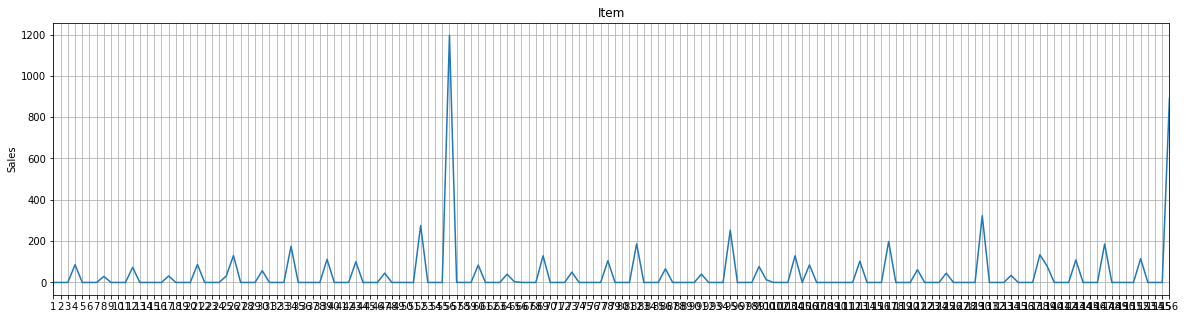

In [10]:
plt.figure(figsize=(20,5))
plt.title('Item')
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data.iloc[0])
plt.plot(x_range[:0],pred.detach().numpy()[:0])
plt.show()

# Predicted values

In [12]:
predicted_values = pred.detach().numpy().squeeze().tolist()
predicted_values = [int(i) for i in predicted_values]
predicted_values

[43,
 4,
 55,
 55,
 55,
 19,
 55,
 55,
 0,
 42,
 37,
 50,
 47,
 7,
 5,
 8,
 54,
 55,
 27,
 1,
 4,
 0,
 30,
 54,
 55,
 55,
 5,
 55,
 34,
 5,
 50,
 13,
 10,
 34,
 0,
 49,
 5,
 55,
 13,
 14,
 0,
 0,
 0,
 55,
 55,
 14,
 11,
 39,
 35,
 55,
 54,
 35,
 0,
 -5,
 13,
 7,
 11,
 54,
 1,
 41,
 35,
 -1,
 42,
 4,
 55,
 9,
 0,
 16,
 19,
 48,
 14,
 16,
 5,
 5,
 0,
 55,
 0,
 0,
 0,
 12,
 6,
 0,
 5,
 0,
 19,
 55,
 28,
 0,
 11,
 55,
 0,
 43,
 0,
 50,
 0,
 10,
 20,
 0,
 5,
 5,
 55,
 0,
 30,
 4,
 0,
 37,
 0,
 15,
 0,
 0,
 5,
 0,
 5,
 7,
 41,
 49,
 0,
 1,
 4,
 17,
 50,
 19,
 14,
 55,
 6,
 0,
 47,
 14,
 14,
 1,
 55,
 4,
 1,
 0,
 -1,
 47,
 0,
 10,
 0,
 39,
 0,
 35,
 44,
 22,
 55,
 11,
 0,
 1,
 3,
 3,
 -2,
 0,
 0,
 0,
 6,
 1,
 9,
 0,
 0,
 5,
 4,
 15,
 45,
 11,
 0,
 5,
 0,
 19,
 2,
 0,
 3,
 22,
 2,
 6,
 4,
 -1,
 35,
 55,
 19,
 0,
 9,
 4,
 55,
 44,
 24,
 0,
 0,
 0,
 0,
 2,
 38,
 9,
 0,
 10,
 5,
 0,
 0,
 4,
 0,
 0,
 4,
 0,
 24,
 0,
 0,
 47,
 0,
 0,
 0,
 55,
 5,
 55,
 48,
 27,
 25,
 5,
 19,
 5,
 1,
 0,
 7,
 34,
 0